# Sentinel 2 Cloudless Mosaic

This tutorial constructs a *cloudless mosaic* (also known as a composite) from a time series of [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) images and is modified from the example notebook provided by Microsoft. This notebook performs the following steps:

* Find a time series of images within a bounding box
* Stack those images together into a single array
* Mask clouds and cloud shadows
* Synthesize a panchromatic band by averageing Red, Green, Blue and NIR bands
* Compute the cloudless mosaic by taking a median
* Save the result to a GeoTiff

This notebook is designed for the processing of large areas, so tasks like plotting that are useful but resource-intensive are omitted

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr
import pandas as pd

import rasterio.features
import rioxarray
import stackstac
import pystac_client
import planetary_computer

import pyproj
from shapely.ops import transform
from shapely.geometry import Polygon

import xrspatial.multispectral as ms

import dask
from dask_gateway import GatewayCluster
from dask import visualize

import itertools
from datetime import datetime
from tqdm.notebook import tqdm

import geopandas as gpd
from pathlib import Path
from datetime import datetime

## Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
# Set up the cluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
client = cluster.get_client()
cluster.adapt(minimum=4, maximum=32)

In [3]:
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.33fc3454b87449f9a5df399607fcaa05/status


## Discover data

In this step we define our bounding box by creating a Shapely Polygon object. The Polygon object is created from a set of coordinate pairs in **Latitude and Longitude** (epsg 3857). A simple way of getting the coordinate pairs is by creating a bounding box in Google Earth, saving it to a kml, then opening it as a text file and copying the coordinates.

At this point, you'll have to decide if you want to process multiple years at once, or if you want to process the years separately. This decision comes down to how much compute power you have access to. For the Dask cluster parameters specified, `cluster.adapt(minimum=4, maximum=24)`, the maximum amount of images used should be less than 200. You can alter the number of images used by changing the values of `date_range`, `max_cloud`, and `pol`.

In [5]:
#proroa: R129, T60GUA & T60HUB
#andrew: R129, T60GVA
#bird: R129, T60HUB

# setting options
date_range = '2016-01-01/2022-01-01'
frame = 'T60HUB'
orbit = 'R129'
max_cloud_image = 33
max_cloud_bbox = 1

# get bounding box (minx, miny, maxx, maxy)
gdf = gpd.read_file('poroa.geojson').to_crs('EPSG:4326')
bbox = tuple(gdf.total_bounds)

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime=date_range,
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"gte":0,"lte": max_cloud_image}},
)

# Get items with the correct relative orbit
items = list(search.get_items())

Now we restrict the results to the same orbit

In [7]:
# grab ids
ids = np.array([x.id.split('_') for x in items])

# get correct orbit
ids = ids[ids[:,3] == orbit]

# get correct frame
ids = ids[ids[:,4] == frame]

# grab valid ids
valid_ids = ['_'.join(x) for x in ids]

#subset items
items = [x for x in items if any([y == x.id for y in valid_ids])]

print(f'Number of images before cloud masking is {len(items)}')

Number of images before cloud masking is 98


Depending on the year, this should return about 100-150 images for our study area over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [8]:
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(planetary_computer.sign(item).to_dict())

## Load Data

In this step we load the data and perform some initial cleaing that includes:
* subsetting to our exact bounding box
* removing pixels that correspond clouds and clouds shadows

To perform our cloud masking, we use Sentinel-2's Scene Classification Layer ([SCL](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)) and mask out values 3, 8, 9, and 10.

In [9]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B08","SCL"],
        chunksize=4096,
        resolution=10
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
)

# Get bounding box in projection of data
minx, miny, maxx, maxy = tuple(gdf.to_crs(data.crs).total_bounds)

# Subset data and mask clouds
data = data.sel(x=slice(minx, maxx), y=slice(maxy,miny))

In [10]:
# plt.imshow(data.isel(band=0,time=0))

## Cloud filtering

In [11]:
first = data.groupby('time').first(skipna=False)
valid = xr.where(first.sel(band='SCL',drop=True).isin([3,8,9]),x=0,y=1)

In [12]:
pct_valid = valid.sum(dim=['x','y']).compute().to_numpy() / (data.shape[2] * data.shape[3])
pct_valid = pct_valid.squeeze()
dates = valid.time.to_numpy()

In [13]:
clouds = pd.DataFrame({'date':dates,'pct_valid':pct_valid[:]})

In [14]:
best = clouds.loc[clouds.pct_valid > (100-max_cloud_bbox)/100].copy()

In [15]:
best['year'] = best.date.dt.year
counts = best.groupby('year').count().reset_index()

In [16]:
for i,row in counts.iterrows():
    print(f'Year {row["year"]} contains {row["date"]} images')

Year 2016 contains 2 images
Year 2017 contains 8 images
Year 2018 contains 6 images
Year 2019 contains 11 images
Year 2020 contains 18 images
Year 2021 contains 12 images


In [17]:
best_dates = data.sel(band=["B08"],time=list(best.date)).squeeze()

## Closest Dates

In [18]:
date_df = pd.DataFrame({'date':best.date})
date_df['year'] = date_df.date.dt.year
date_df['doy'] = date_df.date.dt.dayofyear
date_df['month'] = date_df.date.dt.month

In [19]:
good_months = [9,10,11,12]
summer = date_df.loc[date_df.month.isin(good_months)].copy()
doys = [list(zip(x.date,x.doy)) for _,x in summer.groupby('year')]

In [20]:
min_distance = np.inf

for x in tqdm(list(itertools.product(*doys))):
    distance = 0
    for d1,d2 in itertools.combinations(x,2):
        a = d1[1]
        b = d2[1]
        distance += min(abs(a-b),abs(a+365-b),abs(b-a),abs(b+365-a))

    if np.mean(distance) < min_distance:
        min_distance = np.mean(distance)
        date_list = [z[0] for z in x]

  0%|          | 0/405 [00:00<?, ?it/s]

188.0 [Timestamp('2016-11-22 22:16:02.026000'), Timestamp('2017-11-22 22:15:49.027000'), Timestamp('2018-11-12 22:16:01.024000'), Timestamp('2019-11-22 22:15:59.024000'), Timestamp('2020-12-01 22:16:01.024000'), Timestamp('2021-11-01 22:16:09.024000')]


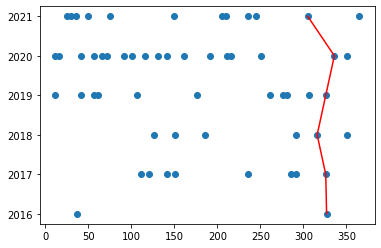

In [21]:
closest_df = date_df.loc[date_df.date.isin(date_list)]
plt.scatter(date_df.doy,date_df.year)
plt.plot(closest_df.doy,closest_df.year,color='red')
print(min_distance,date_list)

In [22]:
for t in closest_df.date:
    time_name = datetime.strftime(t,'%Y%m%d')
    name = f's2_l2_{orbit}_{frame}_{time_name}.tif'
    print(f'Writing {name}...')
    best_dates.sel(time=t).rio.to_raster(name)

Writing s2_l2_R129_T60HUB_20161122.tif...
Writing s2_l2_R129_T60HUB_20171122.tif...
Writing s2_l2_R129_T60HUB_20181112.tif...
Writing s2_l2_R129_T60HUB_20191122.tif...
Writing s2_l2_R129_T60HUB_20201201.tif...
Writing s2_l2_R129_T60HUB_20211101.tif...


## Close cluster
Once we're done with our processing, let's be a good steward of our resources and close our cluster

In [23]:
cluster.close()

## Download Data
And you're done! The completed GeoTiff files should be in the same directory as this notebook, and can be downloaded via Jupyter's GUI